## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

# На нашем курсе по аналитике https://karpov.courses/ секцию про bootstrap читают ребята из https://www.experiment-fest.ru/
# Функция get_bootstrap взята из их занятия по АБ тестам

In [3]:
def cliffsDelta(lst1, lst2, **dull):
    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d #, size                  # Закоментировал возвращение дискретного значения размера эффекта,
                                      # чтобы без проблем использовать bootstrap 

def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'

def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two

In [194]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    N = 1,
    concat = True,
    plot_flag = False,
    colname = ''
):
    if (concat):
        boot_len_1 = len(data_column_1)
        boot_len_2 = len(data_column_2)
        data_for_sample_1 = pd.Series(np.concatenate((data_column_1, data_column_2), axis=None))
        data_for_sample_2 = pd.Series(np.concatenate((data_column_1, data_column_2), axis=None))
        const = statistic(data_column_1) - statistic(data_column_2)
    else:
        boot_len_1 = max([len(data_column_1), len(data_column_2)])
        boot_len_2 = max([len(data_column_1), len(data_column_2)])
        data_for_sample_1 = data_column_1
        data_for_sample_2 = data_column_2
        const = 0
        
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_for_sample_1.sample(
            boot_len_1, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_for_sample_2.sample(
            boot_len_2,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2)) 
    
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    quants.columns = [str(statistic.__name__)]
    
    if (concat):
        p_value = norm.cdf(x = -np.abs(const), loc = np.mean(boot_data), scale = np.std(boot_data)) * 2
    else:
        p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
        p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
        p_value = min(p_1, p_2) * 2
    
    if p_value > 1:
        p_value = 1
        
    # Визуализация
    
    if(plot_flag):
        sns.displot(x = pd_boot_data[0], kind = "kde", fill = True)
        plt.axvline(const, linestyle='-', color='black')
        plt.axvline(quants.values[0], linestyle='--', color='green')
        plt.axvline(quants.values[1], linestyle='--', color='green')
        plt.xlabel('Разность ' + str(statistic.__name__) + ' двух групп')

        plt.title("Histogram of " + colname)
        plt.savefig(f'plots/fighter_human_bootstrap/Histogram of {colname}', bbox_inches='tight')
        plt.show()
        

    if (const >= quants.iloc[:, 0].iloc[0]) & (const <= quants.iloc[:, 0].iloc[1]):
        result = False
    else:
        if (p_value >= 0.01 / N):
            result = False
        else:
            result = True
            
    observed_difference = statistic(data_column_1) - statistic(data_column_2)
       
    return {"result": result,
            "observed_difference": observed_difference,
            "quants": quants,
            "p_value": p_value}

In [195]:
data = pd.read_csv('data/all_data.csv', sep=',')
data = data.drop(['brow_a', 'brow_b', 'brow_c', 'brow_d'], axis=1)
data

,Асимметрия челюсти,Высота бровей,Наклон глаз,Полнота верхней губы,Полнота нижней губы,Асимметрия размера глаз,Ширина посадки глаз,Скулы,Форма головы,Верхнее веко,Асимметрия брови,Наклон бровей,Размер рта,Асимметрия наклона глаз,Асимметрия носа,Размер глаз,Оттопыренность ушей,Ширина челюсти,Уголки рта,Class
0,3.390337,0.155163,-7.744183,0.728999,5.310254,0.981586,0.720082,-1.353690,1.308804,0.349305,0.525278,11.811265,31.003218,-4.353457,-4.314198,4.716563,24.994238,0.893839,-1.834935,warrior
1,0.009935,0.225912,-9.292315,1.778055,5.545871,1.013628,0.817481,-6.867299,1.483796,0.820615,-0.836305,3.376133,42.581685,-0.997495,-1.984013,5.088016,12.242349,0.915261,35.596608,warrior
2,0.891460,0.141038,-12.152457,1.414088,6.599077,0.937218,0.739006,-0.005200,1.537365,0.550704,1.371180,20.424357,35.835962,1.669998,-0.466894,5.429823,18.854505,0.886362,9.021793,warrior
3,-2.407352,0.226568,2.480188,1.533930,7.669650,1.002826,0.859598,-2.441267,1.252503,0.766965,2.398082,12.194204,39.182829,1.828180,-2.996390,5.691325,14.572335,0.913848,-11.036772,warrior
4,0.626843,0.172757,-16.717817,1.956183,8.802824,0.991575,0.829462,15.776568,1.302185,0.236132,2.277609,19.178883,41.091489,1.575153,-0.538334,5.136880,8.802824,0.930010,2.726311,warrior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183,-4.743319,0.159970,-12.518257,0.676581,5.936575,1.066776,0.826851,8.034751,1.343466,0.348165,0.390438,21.587770,35.898508,3.368687,0.097792,6.165936,4.775866,0.872903,28.489986,human
3184,-3.517170,0.277768,-5.068018,2.166255,8.317798,1.010103,0.942079,0.021125,1.536128,1.027160,0.194032,7.177718,39.614944,0.745327,-0.185093,5.853943,4.813901,0.866637,0.098037,human
3185,2.583132,0.197724,-10.422874,1.140166,9.679354,0.959467,0.912630,6.698992,1.459632,0.367528,-1.120887,19.736230,40.318836,-1.294121,-2.154311,5.969982,12.292417,0.853945,5.806727,human
3186,6.999978,0.224875,0.682060,1.138010,4.355265,0.976121,0.714384,21.841788,1.393747,0.599271,1.228379,10.462251,35.634731,0.682060,-2.289321,4.618274,20.148377,0.927516,8.585034,human


In [196]:
data_norm = data.copy()
for col in tqdm(data.columns[:-1]):
    data_norm[col] = (data_norm[col] - data_norm[col].quantile(0.01)) / (data_norm[col].quantile(0.99) - data_norm[col].quantile(0.001))
    

  0%|          | 0/19 [00:00<?, ?it/s]

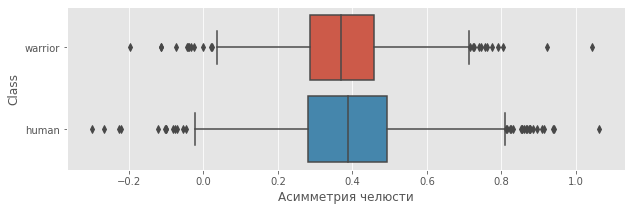

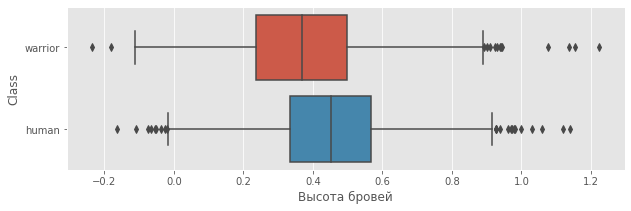

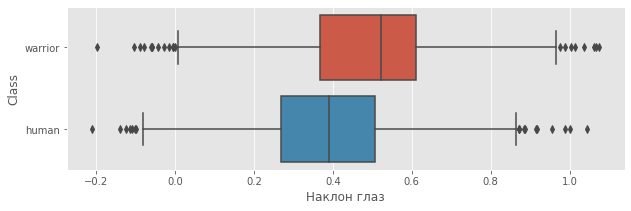

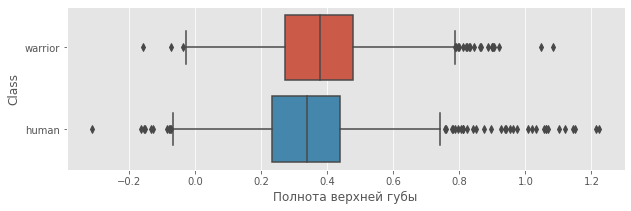

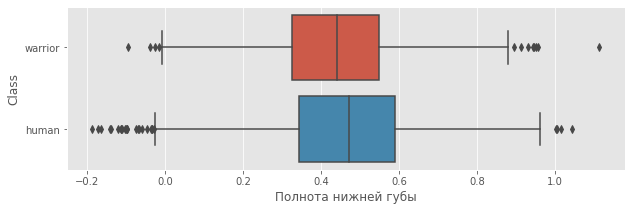

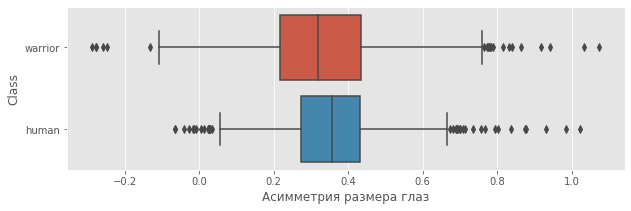

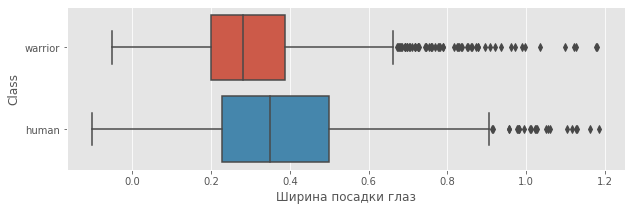

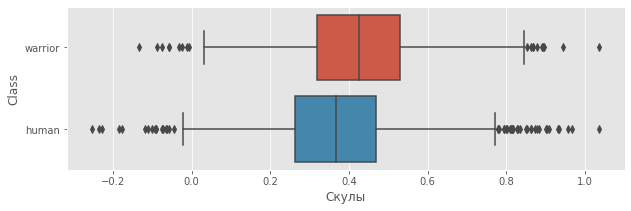

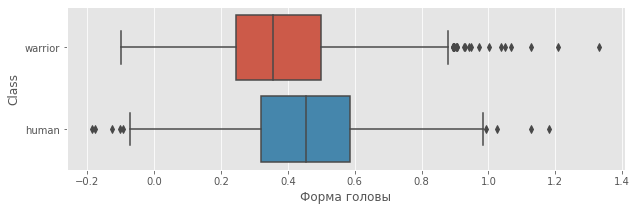

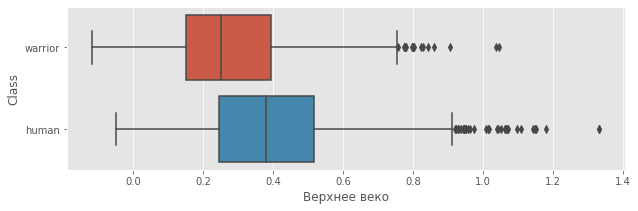

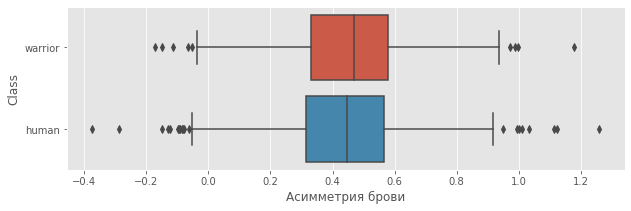

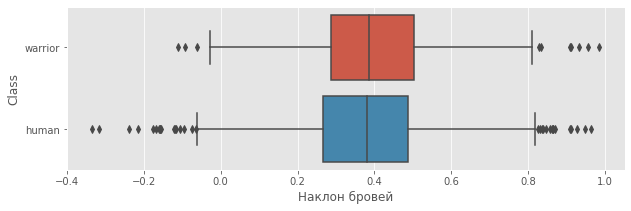

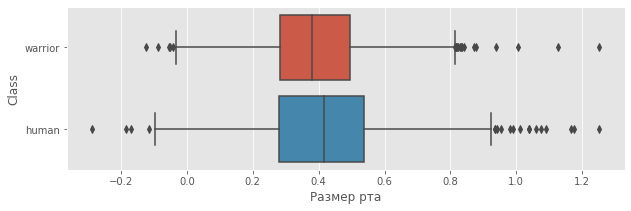

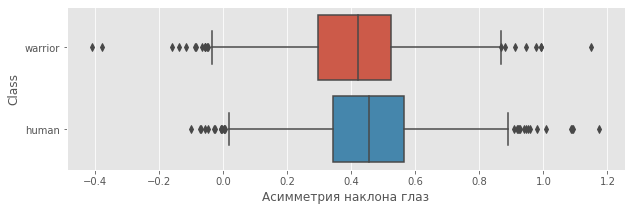

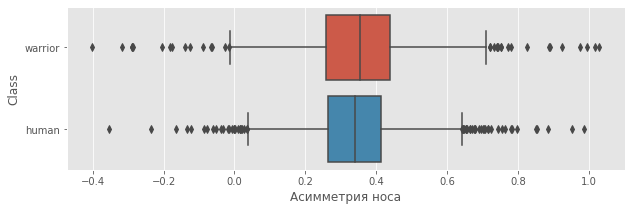

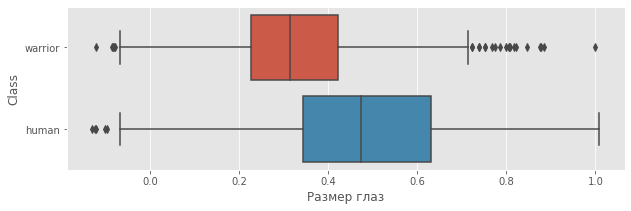

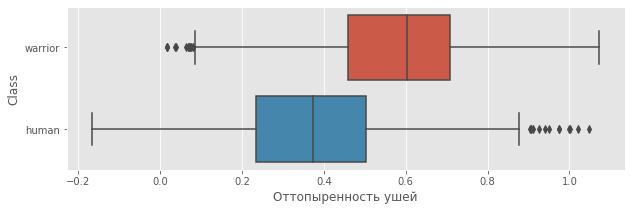

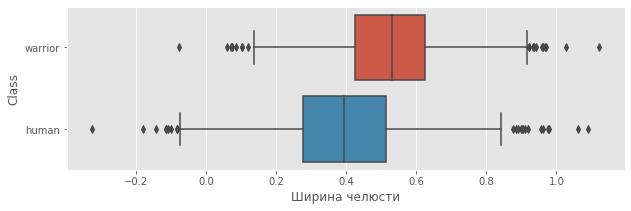

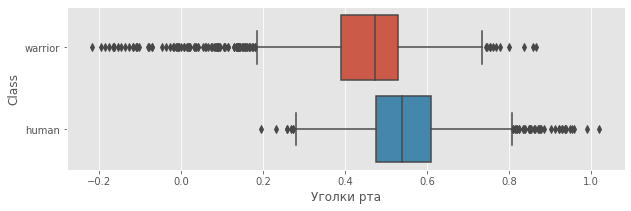

In [204]:
for i in data_norm.columns[0:19]:
    f, ax = plt.subplots(figsize=(10, 3))
    sns.boxplot(data=data_norm, x=i, y="Class")
    plt.savefig(f'plots/fighter_human_boxplot/{i}', bbox_inches='tight')
    plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

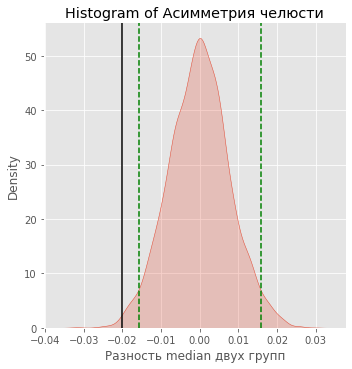

p_value:  0.011492077260857539 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

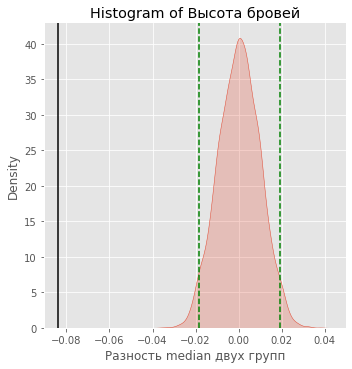

p_value:  3.0709604715452672e-18 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

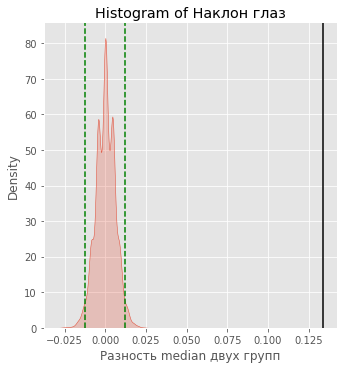

p_value:  3.6374579435140343e-109 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

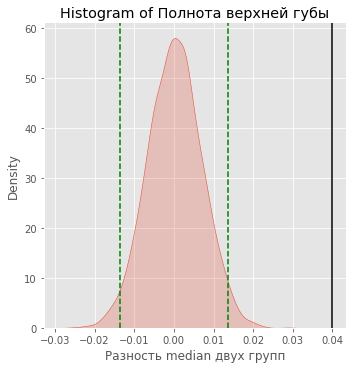

p_value:  5.0628611777886835e-09 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

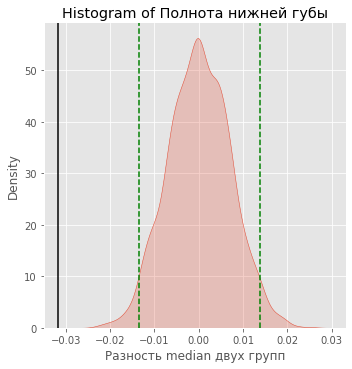

p_value:  6.56561321163847e-06 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

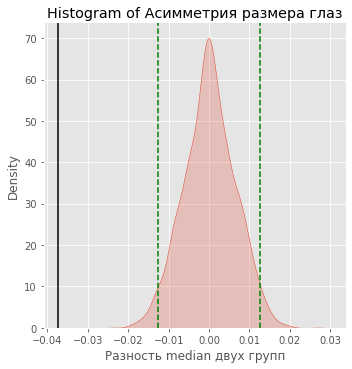

p_value:  4.990209059160016e-09 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

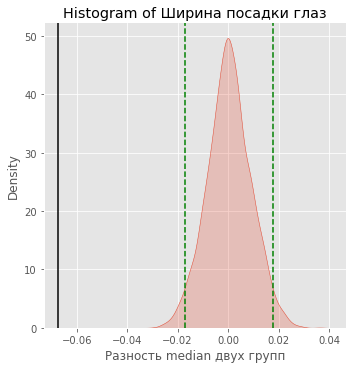

p_value:  8.038546122745038e-15 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

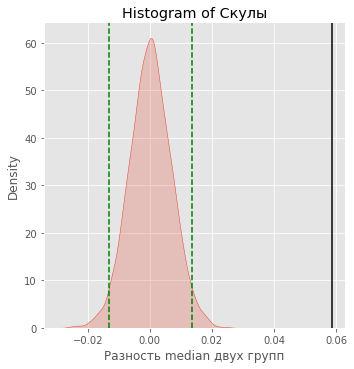

p_value:  7.540998768988537e-18 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

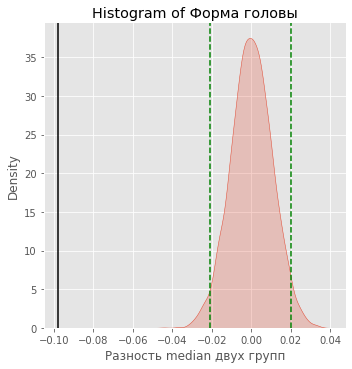

p_value:  9.646100665406756e-21 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

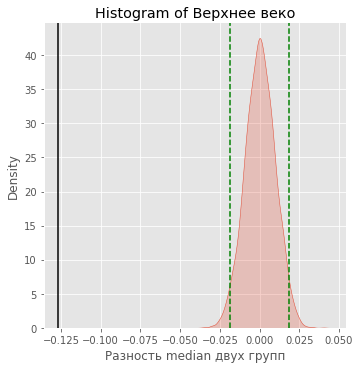

p_value:  4.3257604258366897e-41 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

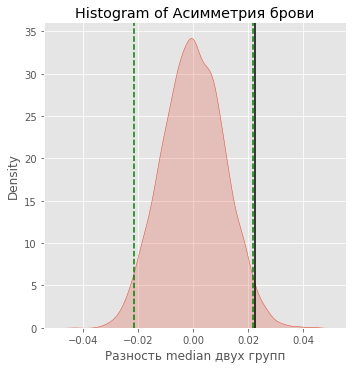

p_value:  0.04617042972996093 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

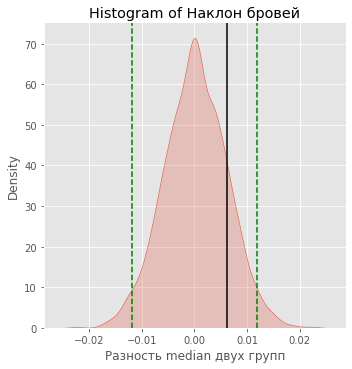

p_value:  0.28186980542276385 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

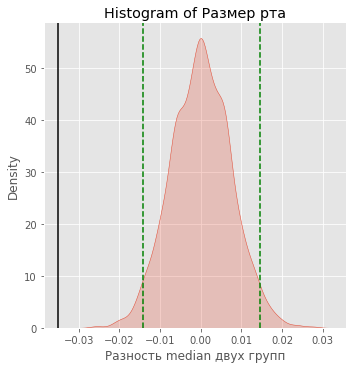

p_value:  2.0613624421904797e-06 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

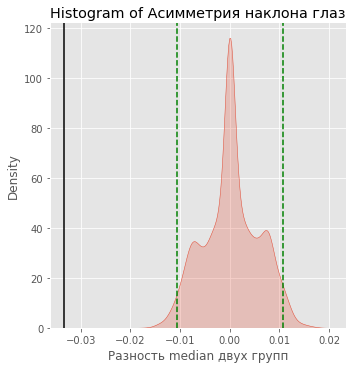

p_value:  1.6445878601073103e-09 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

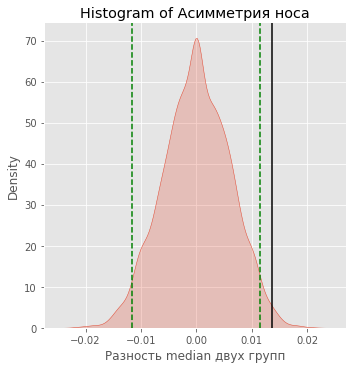

p_value:  0.024352384819926035 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

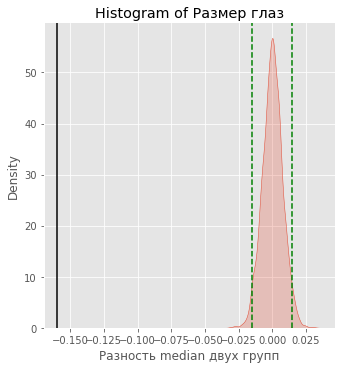

p_value:  2.6531243977582137e-98 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

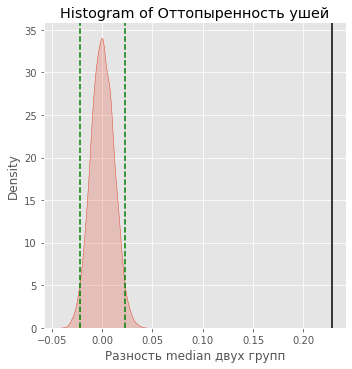

p_value:  2.1590254106534918e-89 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

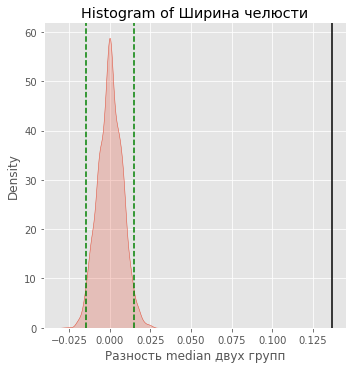

p_value:  5.42597376325496e-74 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

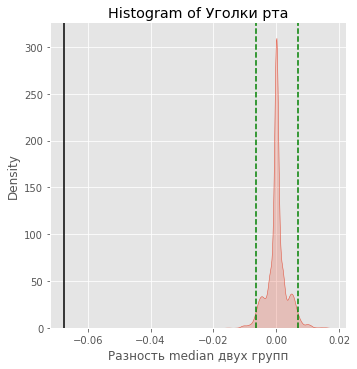

p_value:  7.963814094603322e-101 Statistical value:  True


In [198]:
war = data_norm[data_norm.Class == 'warrior']
hum = data_norm[data_norm.Class == 'human']

l_bot_quant = []
l_top_quant = []
l_observed_difference = []
l_p_value = []
l_result = []

s = np.median
n = 19 # Поправка на множественное сравнение (количество проверяемых гипотез)
for i in data.columns[0:19]:
    res = get_bootstrap(
        war[i], # числовые значения первой выборки
        hum[i], # числовые значения второй выборки
        boot_it = 5000, # количество бутстрэп-подвыборок
        statistic = s, # интересующая нас статистика
        bootstrap_conf_level = 0.95,
        N = n,
        concat = True,
        plot_flag = True,
        colname = i)
    
    l_observed_difference.append(res['observed_difference'])
    l_p_value.append(res['p_value'])
    l_result.append(res['result'])
    l_bot_quant.append(res['quants'].iloc[:, 0].iloc[0])
    l_top_quant.append(res['quants'].iloc[:, 0].iloc[1])
    
    print("p_value: ", res['p_value'], \
          "Statistical value: ", res['p_value'] < (0.01 /38))
    

  0%|          | 0/5000 [00:00<?, ?it/s]

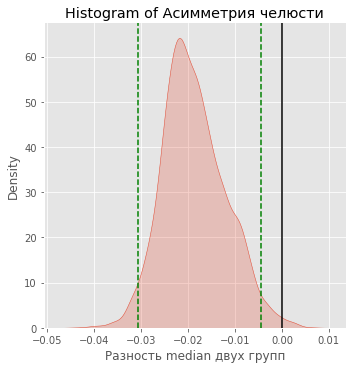

p_value:  0.005438108546547362 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

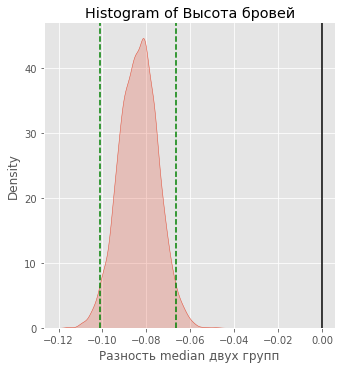

p_value:  1.1902467558438702e-21 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

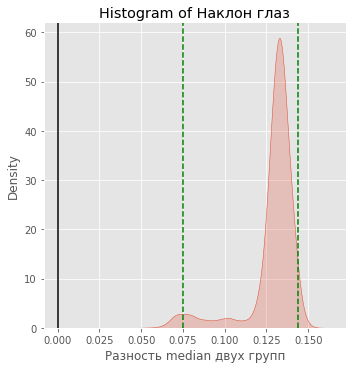

p_value:  1.2471619182065355e-16 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

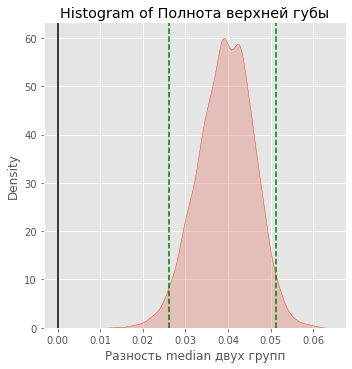

p_value:  1.360993388438671e-09 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

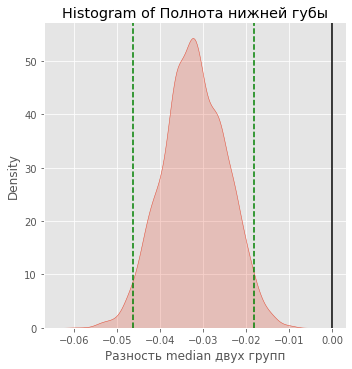

p_value:  1.4129398160323813e-05 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

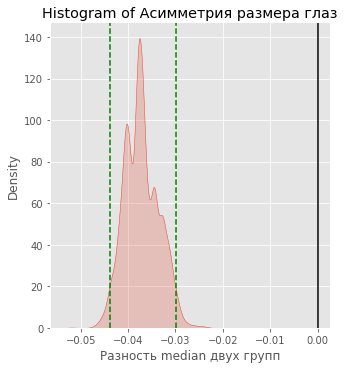

p_value:  8.065539632246635e-25 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

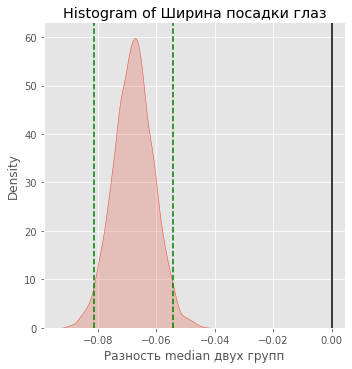

p_value:  5.561450239523588e-23 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

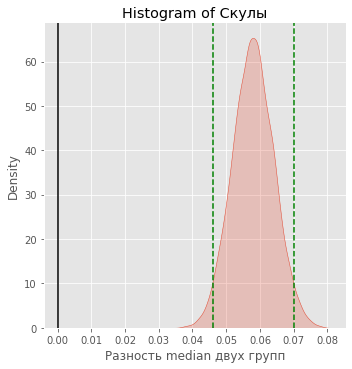

p_value:  2.695560725139894e-21 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

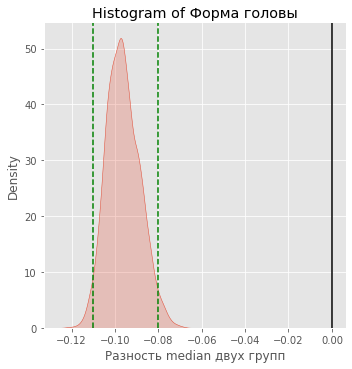

p_value:  9.046899709625598e-36 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

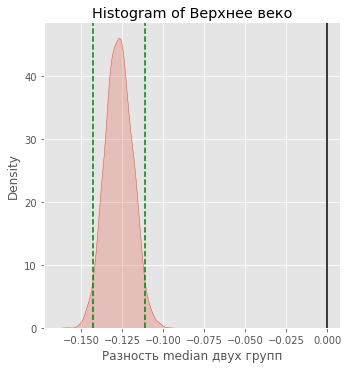

p_value:  7.389258091710977e-53 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

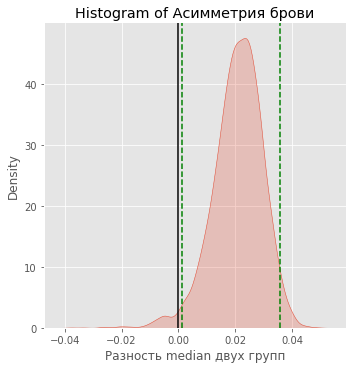

p_value:  0.019271689097975195 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

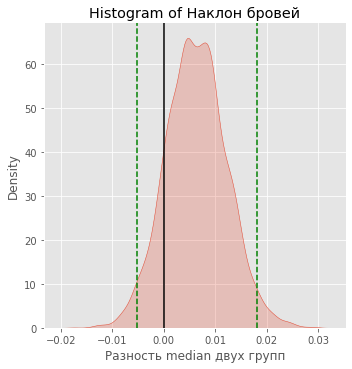

p_value:  0.29484393609998294 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

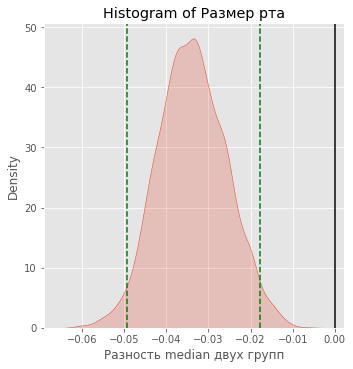

p_value:  2.8751173387105224e-05 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

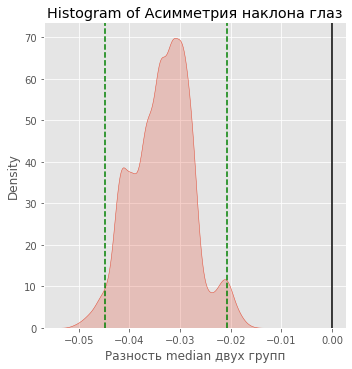

p_value:  1.1583821682414096e-08 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

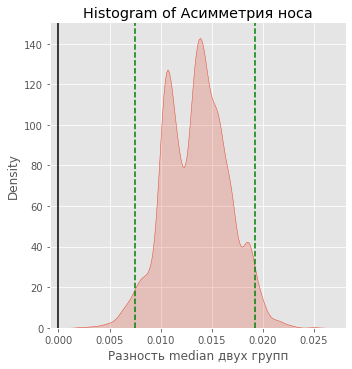

p_value:  1.0074444881286355e-05 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

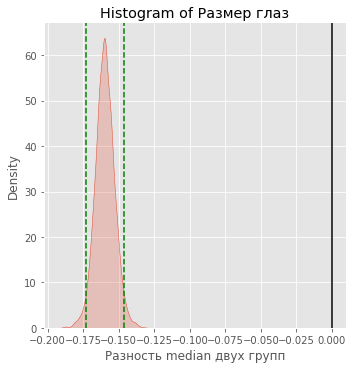

p_value:  1.6753668310829037e-120 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

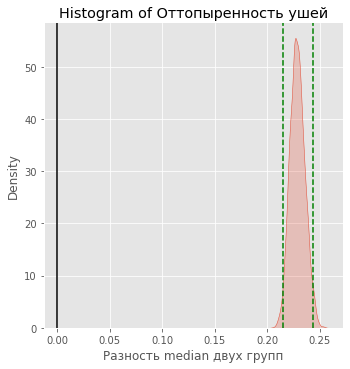

p_value:  9.918882078180791e-226 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

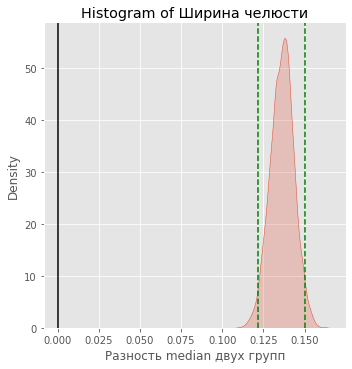

p_value:  3.8351481008036323e-79 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

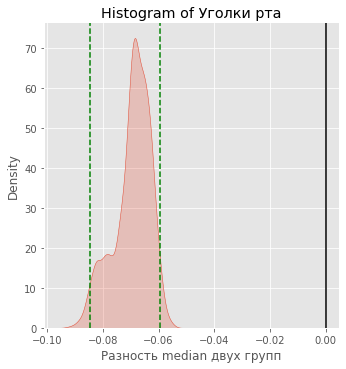

p_value:  7.588965215165888e-26 Statistical value:  True


In [202]:
war = data_norm[data_norm.Class == 'warrior']
hum = data_norm[data_norm.Class == 'human']

l_bot_quant = []
l_top_quant = []
l_observed_difference = []
l_p_value = []
l_result = []

s = np.median
n = 19 # Поправка на множественное сравнение (количество проверяемых гипотез)
for i in data.columns[0:19]:
    res = get_bootstrap(
        war[i], # числовые значения первой выборки
        hum[i], # числовые значения второй выборки
        boot_it = 5000, # количество бутстрэп-подвыборок
        statistic = s, # интересующая нас статистика
        bootstrap_conf_level = 0.95,
        N = n,
        concat = False,
        plot_flag = True,
        colname = i)
    
    l_observed_difference.append(res['observed_difference'])
    l_p_value.append(res['p_value'])
    l_result.append(res['result'])
    l_bot_quant.append(res['quants'].iloc[:, 0].iloc[0])
    l_top_quant.append(res['quants'].iloc[:, 0].iloc[1])
    
    print("p_value: ", res['p_value'], \
          "Statistical value: ", res['p_value'] < (0.01 /38))
    

In [201]:
cols = data_norm.columns[:19]
res_boostrap = pd.DataFrame([cols, l_observed_difference, l_bot_quant, l_top_quant, l_p_value, l_result])
res_boostrap = res_boostrap.T
res_boostrap.columns = ['Feature', 'Медиана наблюдаемой разницы, %', 
                        'Нижняя граница доверительного интервала', 
                        'Верхняя граница доверительного интервала', 'p_value', 'Значимость']
res_boostrap['p_value'] = res_boostrap['p_value'].astype('float')
res_boostrap['Медиана наблюдаемой разницы, %'] = res_boostrap['Медиана наблюдаемой разницы, %']*100

res_boostrap.sort_values(by=['p_value'], ascending=False).reset_index(drop=True)

,Feature,"Медиана наблюдаемой разницы, %",Нижняя граница доверительного интервала,Верхняя граница доверительного интервала,p_value,Значимость
0,Наклон бровей,0.626754,-0.011813,0.011825,2.818698e-01,False
1,Асимметрия брови,2.24932,-0.021664,0.021832,4.617043e-02,False
2,Асимметрия носа,1.360671,-0.011664,0.011478,2.435238e-02,False
3,Асимметрия челюсти,-2.000213,-0.01568,0.015786,1.149208e-02,False
4,Полнота нижней губы,-3.184953,-0.013375,0.013938,6.565613e-06,True
5,Размер рта,-3.518789,-0.01426,0.014662,2.061362e-06,True
6,Полнота верхней губы,3.985307,-0.013482,0.013566,5.062861e-09,True
7,Асимметрия размера глаз,-3.751339,-0.012755,0.012508,4.990209e-09,True
8,Асимметрия наклона глаз,-3.344326,-0.010528,0.010797,1.644588e-09,True
9,Ширина посадки глаз,-6.760738,-0.017146,0.01773,8.038546e-15,True
